## FADM-GPS : Frequency attributed diffusion model for generating pulsatile signals 

In [1]:
import sys
# setting path
sys.path.append('../')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import copy
from argparse import ArgumentParser
import seaborn as sns
import pandas as pd
import pickle

from Benchmarks.Models.BenchmarkCaller import *
from Utilities.EvaluationMain import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams
from Utilities.Visualization import GenConArange
from Utilities.Visualization import *


## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))         

In [2]:
def Denorm (NormX, MaxX, MinX):
    return NormX * (MaxX - MinX) + MinX 

def MAPECal (TrueData, PredSigRec, MaxX, MinX):
    # Denormalization
    DenormTrueData = Denorm(TrueData, MaxX, MinX).copy()
    DenormPredSigRec = Denorm(PredSigRec, MaxX, MinX).copy()
   
    # MAPE
    MAPEdenorm = np.mean(np.abs((DenormTrueData - DenormPredSigRec) / DenormTrueData)) * 100
    MAPEnorm = np.mean(np.abs(((TrueData+1e-7) - PredSigRec) / (TrueData+1e-7))) * 100

    return MAPEnorm, MAPEdenorm


def MSECal (TrueData, PredSigRec, MaxX, MinX):
    # Denormalization
    DenormTrueData = Denorm(TrueData, MaxX, MinX).copy()
    DenormPredSigRec = Denorm(PredSigRec, MaxX, MinX).copy()
   
    # MAPE
    MSEdenorm = np.mean((DenormTrueData - DenormPredSigRec)**2)
    MSEnorm = np.mean((TrueData - PredSigRec)**2)
    
    return MSEnorm, MSEdenorm

In [3]:
def Aggregation (ConfigName, ConfigPath, NJ=1, MetricCut = 1., BatSize=3000):

    print()
    print(ConfigName)
    
    # Configuration and Object part
    print('-----------------------------------------------------' )
    print('Loading configurations and objects' )
    ## Loading the model configurations
    EvalConfigs = ReadYaml(ConfigPath)
    ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName, Comp=False)
    
    ## Loading parameters for the evaluation
    Params = LoadParams(ModelConfigSet, EvalConfigs[ConfigName])
    Params['Common_Info'] = EvalConfigs['Common_Info']
    
    ## Object Load path
    ObjLoadPath = './EvalResults/Instances/Obj_'+ConfigName+'_Nj'+str(NJ)+'.pkl'
    SampZjLoadPath = './Data/IntermediateData/'+ConfigName+'_SampZj_'+str(Params['NSelZ'])+'.npy'
    
    
    # Data part
    print('-----------------------------------------------------' )
    print('Loading data')
    ## Loading data
    VallData = np.load('../Data/ProcessedData/Val'+str(Params['SigType'])+'.npy')
    TrData = np.load('../Data/ProcessedData/Tr'+str(Params['SigType'])+'.npy')
    
    
    ## Intermediate parameters 
    SigDim = VallData.shape[1]
    DataSize = VallData.shape[0]
    
    with open('../Data/ProcessedData/SigMax.pkl', 'rb') as f:
        SigMax = pickle.load(f)
    with open('../Data/ProcessedData/SigMin.pkl', 'rb') as f:
        SigMin = pickle.load(f)
    
    
    if 'ART' in ConfigName:
        MaxX, MinX = SigMax['ART'], SigMin['ART']
    elif 'PLETH' in ConfigName:
        MaxX, MinX = SigMax['PLETH'], SigMin['PLETH']
    elif 'II' in ConfigName:
        MaxX, MinX = SigMax['II'], SigMin['II']
    
    # Model part
    print('-----------------------------------------------------' )
    print('Loading model structures')
    ## Calling Modesl
    BenchModel, _, AnalData = ModelCall (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadName)
    
    
    ## The generation model for evaluation
    GenModel = BenchModel.get_layer('ReconModel')
    
    ## The sampling model for evaluation
    Inp_Enc = BenchModel.get_layer('Inp_Enc')
    Zs = BenchModel.get_layer('Zs').output
    
    if Params['SecDataType'] == 'CONDIN':
        Inp_Cond = BenchModel.get_layer('Inp_Cond')
        SampModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)
    else:
        SampModel = Model(Inp_Enc.input, Zs)
    
    
    # Evaluating MAPEs
    ## Prediction
    print('-----------------------------------------------------' )
    print('MAPE calculation')
    
    PredRes = BenchModel.predict(AnalData, batch_size=BatSize, verbose=1)
    if 'FAC' in ConfigName:
        PredSigRec = PredRes[-1]
    else:
        PredSigRec = PredRes
    
    if Params['SecDataType'] == 'CONDIN':
        InpData = AnalData[0]
    else:
        InpData = AnalData
    
    
    ## MAPE    
    MAPEnorm, MAPEdenorm = MAPECal(InpData, PredSigRec, MaxX, MinX)
    ## MSE    
    MSEnorm, MSEdenorm = MSECal(InpData, PredSigRec, MaxX, MinX)
    
    # Evaluating Mutual information
    ## Creating new instances
    NewEval = Evaluator()
    # Populating it with the saved data
    DeserializeObjects(NewEval, ObjLoadPath)
    if Params['SecDataType'] == 'CONDIN':
        NewEval.SecDataType = 'CONDIN'
    else:
        NewEval.SecDataType = False
    
    # Post evaluation of KLD
    ## MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
    PostSamp = NewEval.SelPostSamp( MetricCut)

    ## Calculation of KLD
    NewEval.GenModel = GenModel
    NewEval.KLD_TrueGen(AnalSig=InpData, PlotDist=False) 
    MeanKld_GTTG = (NewEval.KldPSD_GenTrue + NewEval.KldPSD_TrueGen) / 2
    
    
    print(MeanKld_GTTG)
    
    ''' Renaming columns '''
    # r'I(V;Z)'
    # r'I(V; \acute{Z} \mid Z)'
    # r'I(V;\acute{Z})'
    # r'I(V;\acute{\Theta} \mid \acute{Z})'
    # r'I(S;\acute{Z})'
    # r'I(S;\acute{\Theta} \mid \acute{Z})'
    
    MIVals = pd.DataFrame(NewEval.SubResDic)
    if Params['SecDataType'] == 'CONDIN':
        MIVals.columns = [r'(1) I(V;Z)',r'(2) $I(V; \acute{Z} \mid Z)$',  r'(3) $I(V;\acute{Z})$', r'(4) $I(V;\acute{\Theta} \mid \acute{Z})$', r'(5) $I(S;\acute{Z})$', r'(6) $I(S;\acute{\Theta} \mid \acute{Z})$']
    else:
        MIVals.columns = [r'(1) I(V;Z)',r'(2) $I(V; \acute{Z} \mid Z)$']
        
    MIVals['Model'] = ConfigName
    longMI = MIVals.melt(id_vars='Model', var_name='Metrics', value_name='Values')

    return MSEnorm, MSEdenorm, MAPEnorm, MAPEdenorm, longMI, MeanKld_GTTG


In [4]:
Exp = r'ART|II|\d+'  # Regular expression pattern for 'ART', 'II', or any sequence of digits.
YamlPath = './Config/' # Directory path where the YAML configuration files are stored.

EvalConfigList = os.listdir(YamlPath) # Retrieve a list of all files in the YamlPath directory.
EvalConfigList = [i for i in EvalConfigList if 'Eval' in i] # Filter the list to include only files that contain 'Eval' in their names.

# Iterate through each filtered configuration file.
for EvalConfig in EvalConfigList:
    print(EvalConfig)  
    
    # Read the configuration file's contents.
    ModelConfigs = ReadYaml(YamlPath + EvalConfig) 
    # Filter the configurations to include only those with 'ART' or 'II'.
    ConfigNames = [i for i in ModelConfigs if 'ART' in i or 'II' in i]

    # Initialize lists to store results.
    ModelName = []
    MSEnormRes = []
    MSEdenormRes = []
    MAPEnormRes = []
    MAPEdenormRes = []
    MeanKldRes = []
    MItables = pd.DataFrame()  # Initialize an empty DataFrame for MI tables.
    
    # Iterate through each filtered configuration name.
    for ConfigName in ConfigNames:
        # Perform aggregation (custom function) and retrieve results.
        MSEnorm, MSEdenorm, MAPEnorm, MAPEdenorm, longMI, MeanKld_GTTG = Aggregation(ConfigName, YamlPath + EvalConfig, NJ=1)
        
        # Append the results to their respective lists.
        ModelName.append(ConfigName)
        MSEnormRes.append(MSEnorm)
        MSEdenormRes.append(MSEdenorm) 
        MAPEnormRes.append(MAPEnorm)
        MAPEdenormRes.append(MAPEdenorm) # it's reported for reference, it is not used as an official metric in this paper. 
        MeanKldRes.append(MeanKld_GTTG)
        
        # Concatenate the current longMI DataFrame to the MItables DataFrame.
        MItables = pd.concat([MItables, longMI]).copy()
    
    # Extract relevant parts from EvalConfig to name the table.
    TableName = re.findall(Exp, EvalConfig)
    TableName = ''.join(TableName)  # Concatenate the extracted parts.
    
    # Save the MItables to a CSV file.
    MItables.to_csv('./EvalResults/Tables/MI_' + str(TableName) + '.csv', index=False)

    # Save the AccKLDtables to a CSV file.
    DicRes = {'Model': ModelName , 'MeanKldRes': MeanKldRes, 'MSEnorm':MSEnormRes , 'MSEdenorm': MSEdenormRes, 'MAPEnorm': MAPEnormRes, 'MAPEdenorm': MAPEdenormRes }
    AccKLDtables = pd.DataFrame(DicRes)
    AccKLDtables.to_csv('./EvalResults/Tables/AccKLD_' + str(TableName) + '.csv', index=False)

EvalConfigART.yml

BaseVAE_ART_30
-----------------------------------------------------
Loading configurations and objects
-----------------------------------------------------
Loading data
-----------------------------------------------------
Loading model structures
ReconOutLoss added
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame (TFOpLambda)   (None, 20, 50)       0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 50)       11550       ['tf.signal.frame[0][0]']        
    

In [140]:
AnalData.shape

(60000, 1000)

In [82]:
ConfigName

'TCVAE_II_50'

In [81]:
ModelConfigSet

{'LatDim': 50,
 'SigType': 'rawII',
 'ReparaStd': 0.1,
 'Capacity_Z': 0.1,
 'Capacity_TC': 0.01,
 'Capacity_MI': 0.1,
 'BatSize': 2800,
 'NEpochs': 5000,
 'WRec': 1,
 'WZ': 1,
 'WTC': 1,
 'WMI': 1,
 'MnWRec': 50,
 'MnWZ': 0.003,
 'MnWTC': 0.001,
 'MnWMI': 0.001,
 'MxWRec': 50,
 'MxWZ': 0.003,
 'MxWTC': 0.001,
 'MxWMI': 0.001}

In [14]:
YamlPath = './Config/EvalConfigART.yml'
ModelConfigs = ReadYaml(YamlPath)
[i for i in ModelConfigs]

['Common_Info',
 'BaseVAE_ART_30',
 'BaseVAE_ART_50',
 'FACVAE_ART_30',
 'FACVAE_ART_50',
 'ConVAE_ART_30',
 'ConVAE_ART_50',
 'TCVAE_ART_30',
 'TCVAE_ART_50']

In [40]:
ConfigName = 'EvalConfigART'
ConfigSpecName = 'ConVAE_ART_50'
EvalConfigs = ReadYaml(YamlPath)

PermissionError: [Errno 13] Permission denied: './Config/'

In [4]:
ConfigName

'EvalConfigART'

In [6]:
ConfigName = 'BaseVAE_ART_30'
ModelConfigSet, ModelLoadPath = LoadModelConfigs(ConfigName, Comp=False)

# Loading parameters for the evaluation
Params = LoadParams(ModelConfigSet, EvalConfigs[ConfigName])
Params['Common_Info'] = EvalConfigs['Common_Info']

# Object save path
ObjLoadPath = './EvalResults/Instances/Obj_'+ConfigName+'.pkl'
SampZjSavePath = './Data/IntermediateData/'+ConfigName+'_SampZj_'+str(Params['NSelZ'])+'.npy'

# Loading data
TrData = np.load('../Data/ProcessedData/Tr'+str(Params['SigType'])+'.npy').astype('float32')
VallData = np.load('../Data/ProcessedData/Val'+str(Params['SigType'])+'.npy').astype('float32')

# Intermediate parameters 
SigDim = VallData.shape[1]
DataSize = VallData.shape[0]

In [8]:
# Calling Modesl
BenchModel, _, AnalData = ModelCall (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True, Reparam=True, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadPath) 


## The generation model for evaluation
GenModel = BenchModel.get_layer('ReconModel')

## The sampling model for evaluation
Inp_Enc = BenchModel.get_layer('Inp_Enc')
Zs = BenchModel.get_layer('Zs').output

if Params['SecDataType'] == 'CONDIN':
    Inp_Cond = BenchModel.get_layer('Inp_Cond')
    SampModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)
else:
    SampModel = Model(Inp_Enc.input, Zs)

ReconOutLoss added
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame (TFOpLambda)   (None, 20, 50)       0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 50)       11550       ['tf.signal.frame[0][0]']        
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20, 50)      11550       ['bidirectional[0][0]']          
 )                                                                         

In [9]:
Eval = Evaluator(MinFreq = Params['MinFreq'], MaxFreq = Params['MaxFreq'], SimSize = Params['SimSize'], NMiniBat = Params['NMiniBat'], 
       NGen = Params['NGen'], ReparaStdZj = Params['ReparaStdZj'], NSelZ = Params['NSelZ'], SampBatchSize = Params['SampBatchSize'], 
       GenBatchSize = Params['GenBatchSize'], GPU = Params['GPU'])

# Later, when you want to restore those objects
# Create a new instance
NewEval = Evaluator()
# Populate it with the saved data
DeserializeObjects(NewEval, ObjLoadPath)

FileNotFoundError: [Errno 2] No such file or directory: './EvalResults/Instances/Obj_BaseVAE_ART_30.pkl'

In [ ]:
NewEval.

#### Selecting post Samp_Zj for generating plausible signals

In [7]:
# MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
NewEval.SecDataType = 'CONDIN'
MetricCut = 1.
PostSamp = NewEval.SelPostSamp( MetricCut)

The total number of sets in NestedZs: 8902


In [8]:
NewEval.MI_zPSD_ZjZ, NewEval.MI_fcPE_CaCr, NewEval.MI_zPSD_CrZj

(0.9225803589556197, -0.1841267627272357, 1.3445250460054077)

#### Post EvalKld_TrueGen

5/5 [==============================] - 2s 391ms/step
KldPSD_GenTrue:  0.09782205212415489
KldPSD_TrueGen:  0.14973394104820928
MeanKld_GTTG:  0.12377799658618208


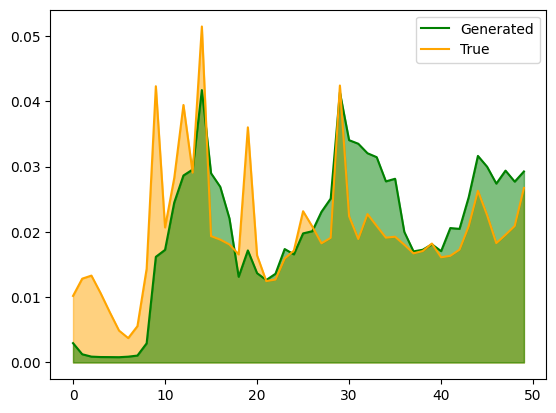

In [121]:
NewEval.GenModel = GenModel
NewEval.KLD_TrueGen(AnalSig=AnalData[0]) 

In [ ]:
def GenSig_CONA (ReconModel, zValue, ConData, N_Gen=200, MinZval = -3., MaxZval = 3., zType='Fixed'):

    if zType=='Random':
        Z_pred=np.random.normal(0, 1, ( N_Gen, LatDim))
    elif zType=='Line' :
        Z_pred = np.linspace(MinZval, MaxZval, N_Gen*LatDim).reshape(N_Gen, -1)
    elif zType=='Fixed':
        Z_pred = zValue
        
        
    ## Generating CON_Arange
    CON_Arange = GenConArange(ConData, N_Gen)

    SigGen = ReconModel([Z_pred, CON_Arange])

    HalfLen = SigGen.shape[1]//2
    FFTRes = np.abs(np.fft.fft(SigGen, axis=-1)[:, :HalfLen]) 
    Amplitude = FFTRes/HalfLen
    
    return SigGen, Amplitude


def HeatMapFreqZ_CONA (ReconModel, ConData, LatDim, ZFix, N_Gen=300, MinFreq=1, MaxFreq=51):
    
    zVal = np.tile(np.zeros(LatDim), (N_Gen,1))
    for KeyVal in ZFix.items():
        zVal[:,KeyVal[0]] = KeyVal[1]
    
    _, Amplitude_ConVar = GenSig_CONA(ReconModel, zVal, ConData, N_Gen=N_Gen, zType='Fixed')
    Heatmap = Amplitude_ConVar[:, MinFreq:MaxFreq]

    fig, ax = plt.subplots(figsize=(7,6))
    cax = fig.add_axes([0.95, 0.25, 0.04, 0.5])

    im = ax.imshow(Heatmap,  cmap='viridis', aspect='auto',interpolation='nearest') 
    ax.set(yticks=np.arange(0, N_Gen)[::20]);
    ax.set(xticks=np.arange(1, MaxFreq)[::5]-0.5, xticklabels=np.arange(1, MaxFreq)[::5]);
    ax.set_xlabel('Frequency', fontsize=16)
    ax.set_ylabel('Conditions given for generating signals', fontsize=16) 

    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()
    
    
def VisReconGivenCON_ZA (ReconModel, LatDim, CON_Given,   N_Gen=300, MinZval = -3., MaxZval = 3., CutLower=-0.1, CutUpper = 0.1):
    
    zVal = np.linspace(MinZval, MaxZval, N_Gen*LatDim).reshape(N_Gen, -1)
    CON_Given = np.tile(CON_Given, (N_Gen,1))
        
    SigGen = ReconModel([zVal, CON_Given])
    
    # Create a colormap and normalize it based on the number of experiments
    cmap = cm.get_cmap('viridis')
    norm = plt.Normalize(0, N_Gen-1)
    norm2 = plt.Normalize(MinZval, MaxZval)


    fig, ax = plt.subplots(figsize=(15, 7))
    for i in range(0, N_Gen):
        color = cmap(norm(i))
        if np.min(zVal[i]) < CutLower or np.max(zVal[i]) > CutUpper:
            ax.plot(SigGen[i], color=color)


    # Create color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('z-value ranges')

    plt.show()
    
    return SigGen



def VisReconExtractCON_ZA (Data, idx,  ReconModel, CON_Given,  N_Gen=300):
    
    Sample = np.tile(Data[idx][None], (N_Gen, 1))
    RecPred = ReconModel([Sample, CON_Given])

    plt.figure(figsize=(15, 5))
    for i in range(N_Gen):
        plt.plot(RecPred[i])
    plt.plot(Data[idx],linestyle='--', color='black', label='True signal')
    plt.legend()
    
    return RecPred

### Qualitative evaluation

#### Exploring candidates using FreqIDs

In [12]:
TrackerCandZ = NewEval.TrackerCand
BestZsMetrics = NewEval.BestZsMetrics
NewEval.CandFreqIDs
LatDim = 30

#### Visualization of signals given Z values

In [13]:
FreqID = 15
ZFixSubID = 0
SelZ =  NewEval.PostSamp[FreqID][ZFixSubID]['TrackZs']

assert ZFixSubID < len(NewEval.PostSamp[FreqID]), 'ZFixSubID must be smaller than ' + str(len(NewEval.PostSamp[FreqID]))

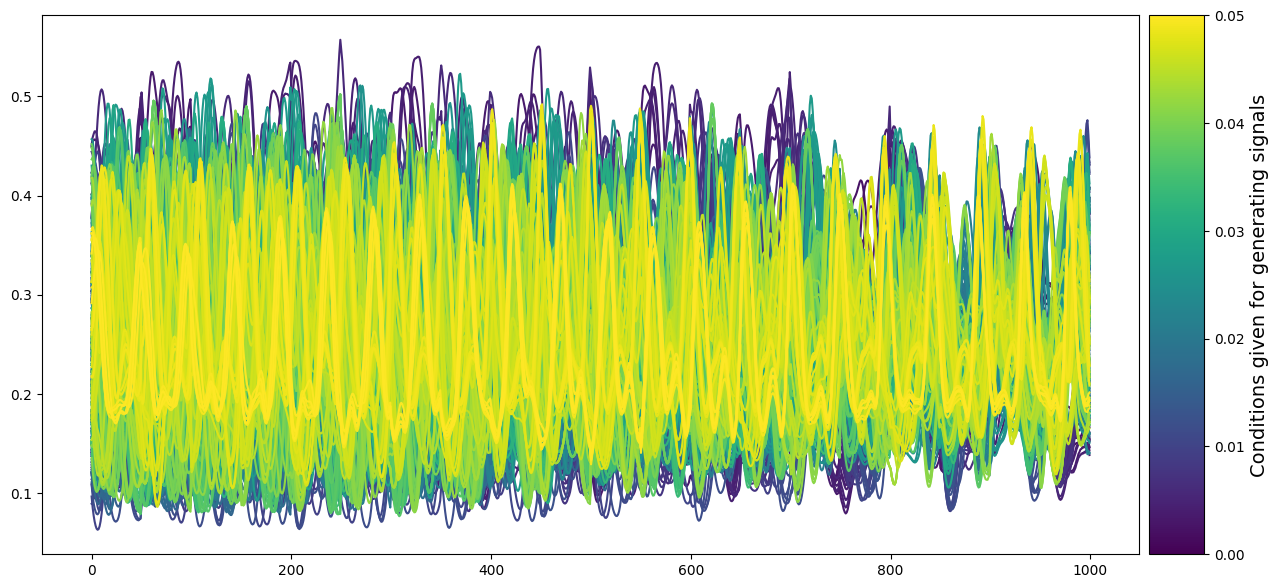

In [14]:
ConData = AnalData[1]
RecPred = VisReconGivenZ_CONA (GenModel, ConData, LatDim, SelZ, N_Gen=300, MinFreqR=0., MaxFreqR=0.05)


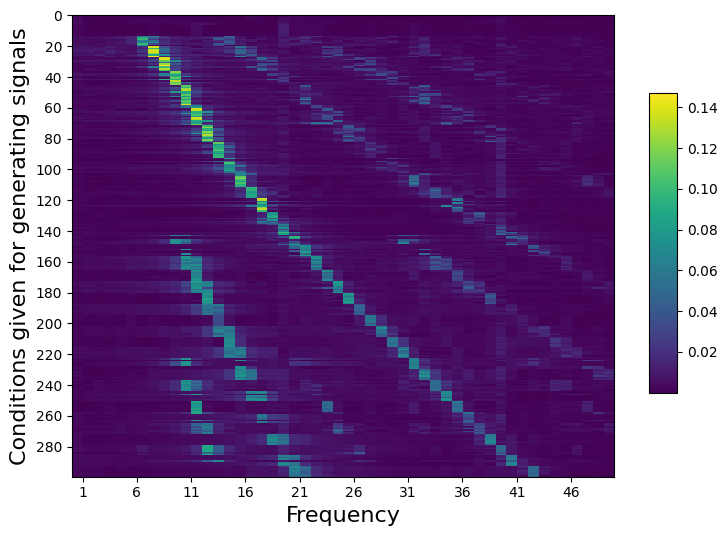

In [15]:
HeatMapFreqZ_CONA (GenModel,  ConData, LatDim, SelZ, N_Gen=300)

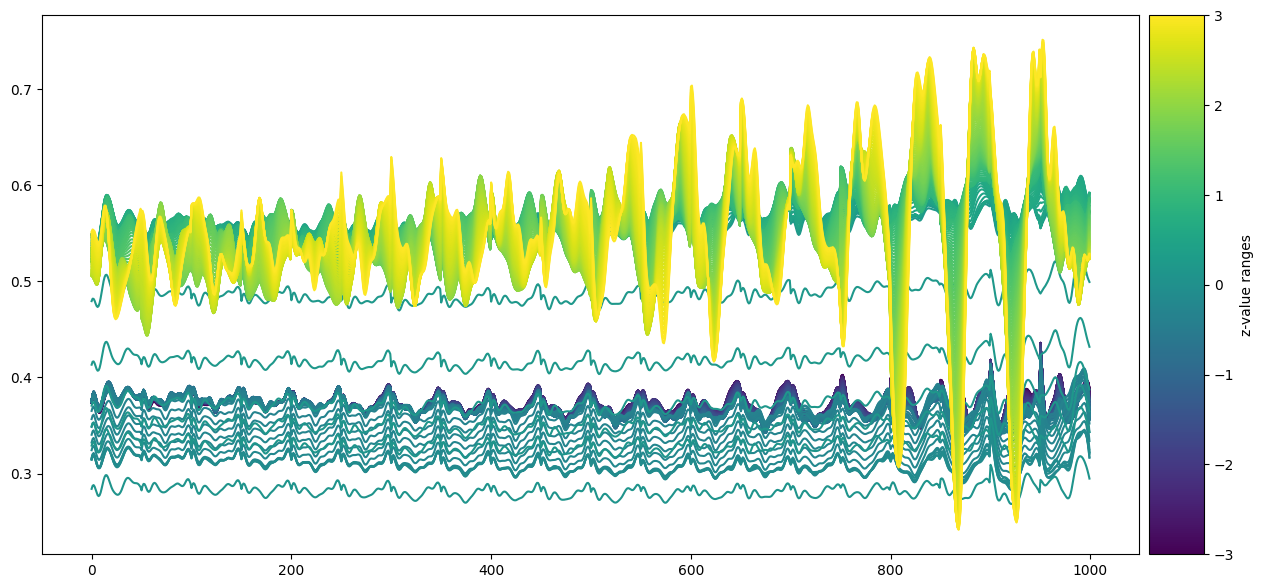

In [16]:
CON_Arange = GenConArange(ConData, 300)
CON_Given = CON_Arange[1]
RecPred = VisReconGivenCON_ZA (GenModel, LatDim, CON_Given,   N_Gen=300, MinZval = -3., MaxZval = 3., CutLower=-0.1, CutUpper = 0.1)

<tf.Tensor: shape=(100, 1000), dtype=float32, numpy=
array([[0.35051927, 0.34348068, 0.33885255, ..., 0.35169542, 0.34674534,
        0.3363854 ],
       [0.15288891, 0.16037676, 0.16945565, ..., 0.24261567, 0.23563108,
        0.22792038],
       [0.24625824, 0.2461357 , 0.249837  , ..., 0.34215516, 0.3376748 ,
        0.33078536],
       ...,
       [0.19322641, 0.19571617, 0.19755183, ..., 0.17158692, 0.1646488 ,
        0.15506093],
       [0.16576014, 0.15010661, 0.13730697, ..., 0.17572826, 0.17582342,
        0.17597243],
       [0.20946848, 0.1912003 , 0.17572127, ..., 0.27001163, 0.26469582,
        0.2556998 ]], dtype=float32)>

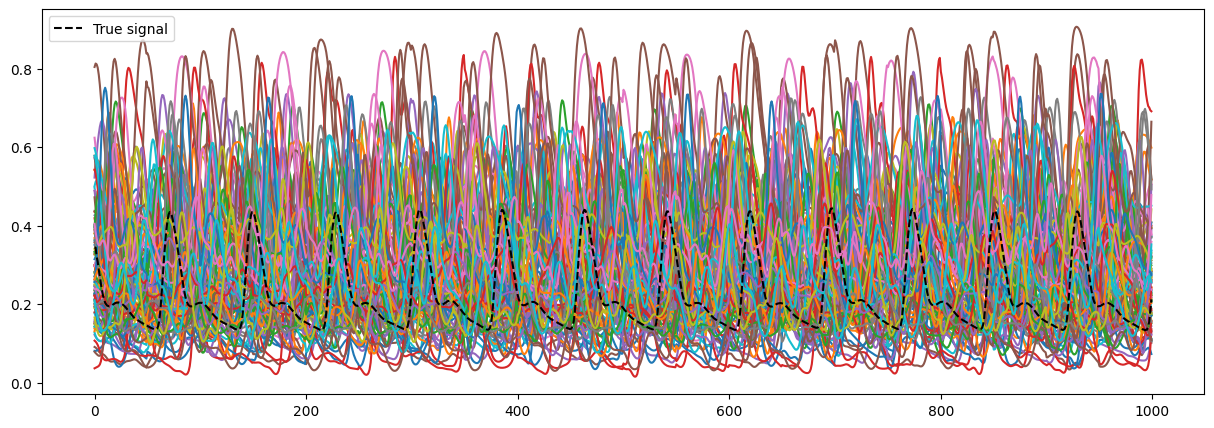

In [17]:
idx = 9871

N_Gen = 100

#BenchModel, _, AnalData = ModelCall (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadPath) 

CON_Arange = GenConArange(ConData, N_Gen)
VisReconExtractCON_ZA (AnalData[0], idx,  BenchModel, CON_Arange,  N_Gen=N_Gen)